# Food Demand Forecasting

## Importing and initiating libraries


In [118]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [125]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy>=1.14.0 in c:\users\saad\anaconda3\lib\site-packages (from category_encoders) (1.19.2)



In [150]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from matplotlib.pylab import rcParams
import category_encoders as ce

Importing the datasets for demand forecasting

In [7]:
train = pd.read_csv('C:/Users/Saad/Desktop/New folder (2)/Food Demand Forecast/Files/train.csv')
meal_info = pd.read_csv('C:/Users/Saad/Desktop/New folder (2)/Food Demand Forecast/Files/meal_info.csv')
ff_center_info = pd.read_csv('C:/Users/Saad/Desktop/New folder (2)/Food Demand Forecast/Files/fulfilment_center_info.csv')
test = pd.read_csv('C:/Users/Saad/Desktop/New folder (2)/Food Demand Forecast/Files/test.csv')
submission = pd.read_csv('C:/Users/Saad/Desktop/New folder (2)/Food Demand Forecast/Files/sample_submission.csv')

## Details of the available datasets

In [22]:
print("Variables in Train :")
print(train.columns.values)

print("\nValues in Test :")
print(test.columns)

print("\nValues in Meal Info :")
print(meal_info.columns)

print("\nValues in Fulfilment center info :")
print(ff_center_info.columns)

print("\nValues in Sample Submission :")
print(submission.columns)



Variables in Train :
['id' 'week' 'center_id' 'meal_id' 'checkout_price' 'base_price'
 'emailer_for_promotion' 'homepage_featured' 'num_orders']

Values in Test :
Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured'],
      dtype='object')

Values in Meal Info :
Index(['meal_id', 'category', 'cuisine'], dtype='object')

Values in Fulfilment center info :
Index(['center_id', 'city_code', 'region_code', 'center_type', 'op_area'], dtype='object')

Values in Sample Submission :
Index(['id', 'num_orders'], dtype='object')


The objective is to forecast the number of orders for the next ten weeks (146 to 155)
However, the test data does NOT contain the target variable. As such, we can only validate the data from the test train split which will be generated from the train dataset. Testing on the test data for model performance numbers will not be possible due to the non-availability of the target variable in the dataset

### Train data

    1. Train data contains the week-wise delivery information for each center.
    2. Data also contains meal and order details
    3. Train data is connected to meal info through the meal_id column
    4. Fulfilment center details can be obtained from the fulfilment_center_info data using the center_id column

In [23]:
train.describe()

id           week      center_id        meal_id  \
count  4.565480e+05  456548.000000  456548.000000  456548.000000   
mean   1.250096e+06      74.768771      82.105796    2024.337458   
std    1.443548e+05      41.524956      45.975046     547.420920   
min    1.000000e+06       1.000000      10.000000    1062.000000   
25%    1.124999e+06      39.000000      43.000000    1558.000000   
50%    1.250184e+06      76.000000      76.000000    1993.000000   
75%    1.375140e+06     111.000000     110.000000    2539.000000   
max    1.499999e+06     145.000000     186.000000    2956.000000   

       checkout_price     base_price  emailer_for_promotion  \
count   456548.000000  456548.000000          456548.000000   
mean       332.238933     354.156627               0.081152   
std        152.939723     160.715914               0.273069   
min          2.970000      55.350000               0.000000   
25%        228.950000     243.500000               0.000000   
50%        296.820000     310.460000               0.000000   
75%        445.230000     458.870000               0.000000   
max        866.270000     866.270000               1.000000   

       homepage_featured     num_orders  
count       456548.00000  456548.000000  
mean             0.10920     261.872760  
std              0.31189     395.922798  
min              0.00000      13.000000  
25%              0.00000      54.000000  
50%              0.00000     136.000000  
75%              0.00000     324.000000  
max              1.00000   24299.000000

    1. week column contains data from week 1 to week 145
    2. emailer_for_promotion and homepage_featured are flags for promotion and meal being featured on the homepage respectively

## Checking for nulls

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [26]:
train.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

There are no null values in the train dataset. Doing the same checks for other relevant datasets-

In [28]:
print(test.isna().sum())
print(meal_info.isna().sum())
print(ff_center_info.isna().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64
meal_id     0
category    0
cuisine     0
dtype: int64
center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64


No null values in any column in all datasets

## Merging train data with meal info and fulfilment center info to get all details in one dataset

In [30]:
# merge data 
data=train.merge(meal_info, on=["meal_id"], how='inner').merge(ff_center_info,on=["center_id"]).sort_values(by=["week"]).reset_index(drop=True)
print(data.shape)
data.head()

(456548, 15)


id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1409622     1        113     2444          658.63      660.63   
2  1203879     1        113     1525          244.50      282.33   
3  1235654     1        113     2704          242.50      280.33   
4  1393327     1         52     1248          247.35      247.35   

   emailer_for_promotion  homepage_featured  num_orders      category  \
0                      0                  0         177     Beverages   
1                      0                  0          14       Seafood   
2                      0                  0          14  Other Snacks   
3                      0                  0         121  Other Snacks   
4                      0                  0          81     Beverages   

       cuisine  city_code  region_code center_type  op_area  
0         Thai        647           56      TYPE_C      2.0  
1  Continental        680           77      TYPE_C      4.0  
2         Thai        680           77      TYPE_C      4.0  
3         Thai        680           77      TYPE_C      4.0  
4       Indian        685           56      TYPE_B      5.6

In [36]:
data.describe().T
#Transposing the matrix as it is more readable in this orientation

id           week      center_id        meal_id  \
count  4.565480e+05  456548.000000  456548.000000  456548.000000   
mean   1.250096e+06      74.768771      82.105796    2024.337458   
std    1.443548e+05      41.524956      45.975046     547.420920   
min    1.000000e+06       1.000000      10.000000    1062.000000   
25%    1.124999e+06      39.000000      43.000000    1558.000000   
50%    1.250184e+06      76.000000      76.000000    1993.000000   
75%    1.375140e+06     111.000000     110.000000    2539.000000   
max    1.499999e+06     145.000000     186.000000    2956.000000   

       checkout_price     base_price  emailer_for_promotion  \
count   456548.000000  456548.000000          456548.000000   
mean       332.238933     354.156627               0.081152   
std        152.939723     160.715914               0.273069   
min          2.970000      55.350000               0.000000   
25%        228.950000     243.500000               0.000000   
50%        296.820000     310.460000               0.000000   
75%        445.230000     458.870000               0.000000   
max        866.270000     866.270000               1.000000   

       homepage_featured     num_orders      city_code    region_code  \
count       456548.00000  456548.000000  456548.000000  456548.000000   
mean             0.10920     261.872760     601.553399      56.614566   
std              0.31189     395.922798      66.195914      17.641306   
min              0.00000      13.000000     456.000000      23.000000   
25%              0.00000      54.000000     553.000000      34.000000   
50%              0.00000     136.000000     596.000000      56.000000   
75%              0.00000     324.000000     651.000000      77.000000   
max              1.00000   24299.000000     713.000000      93.000000   

             op_area  
count  456548.000000  
mean        4.083590  
std         1.091686  
min         0.900000  
25%         3.600000  
50%         4.000000  
75%         4.500000  
max         7.000000

## EDA
As total number of rows are <500,000 , the Exploratory Data Analysis has been performed majorly on excel and tableau.
The insights have been generated based on the findings in this stage.


<AxesSubplot:>

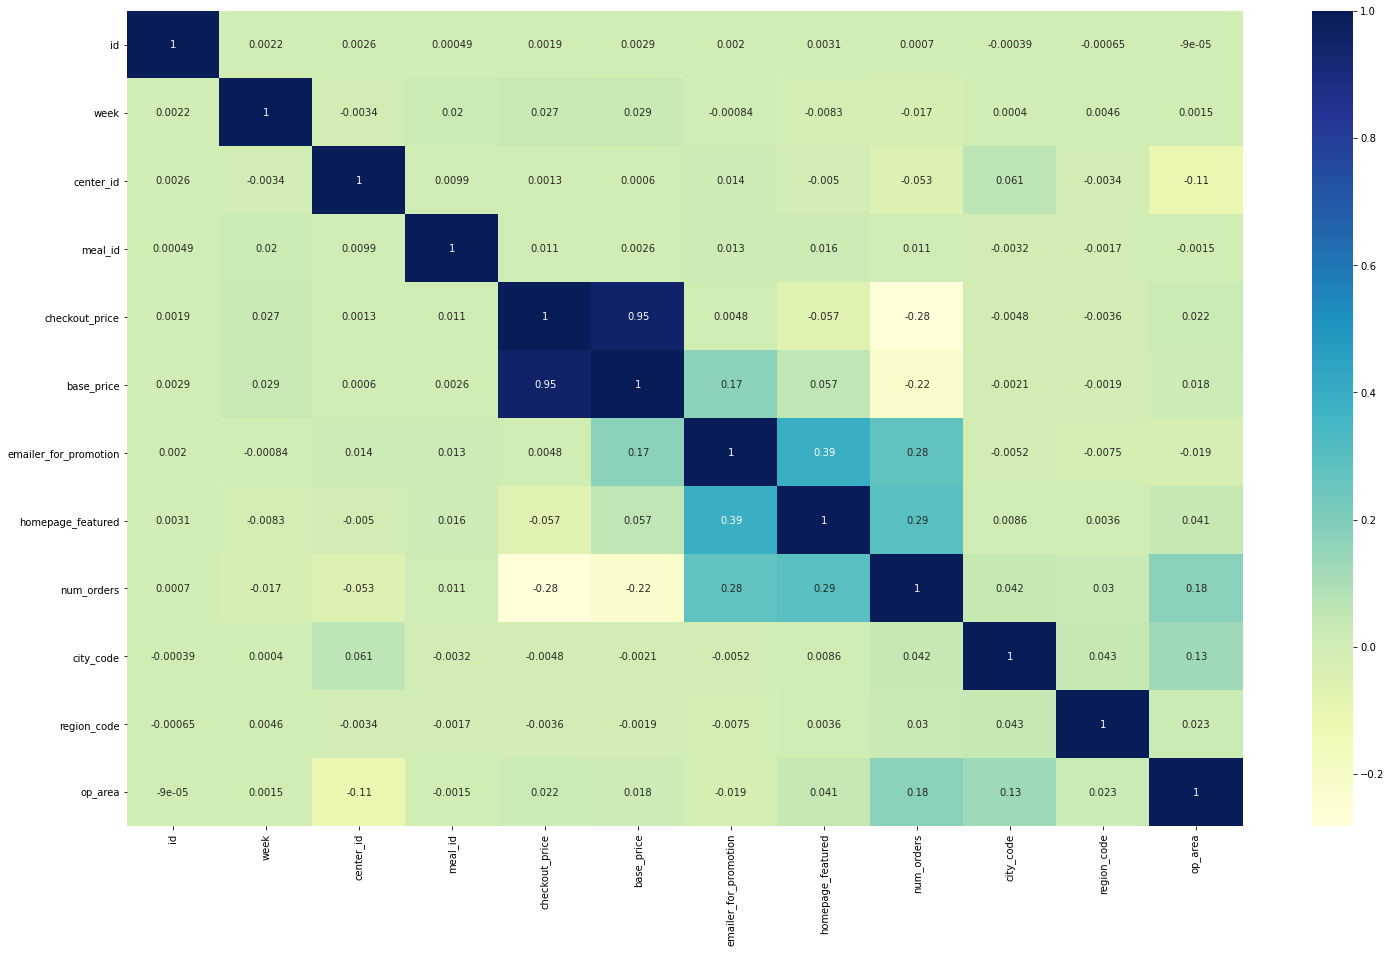

In [56]:
plt.figure(figsize=(25,15))
c=data.corr()
sns.heatmap(c,cmap="YlGnBu",annot=True)

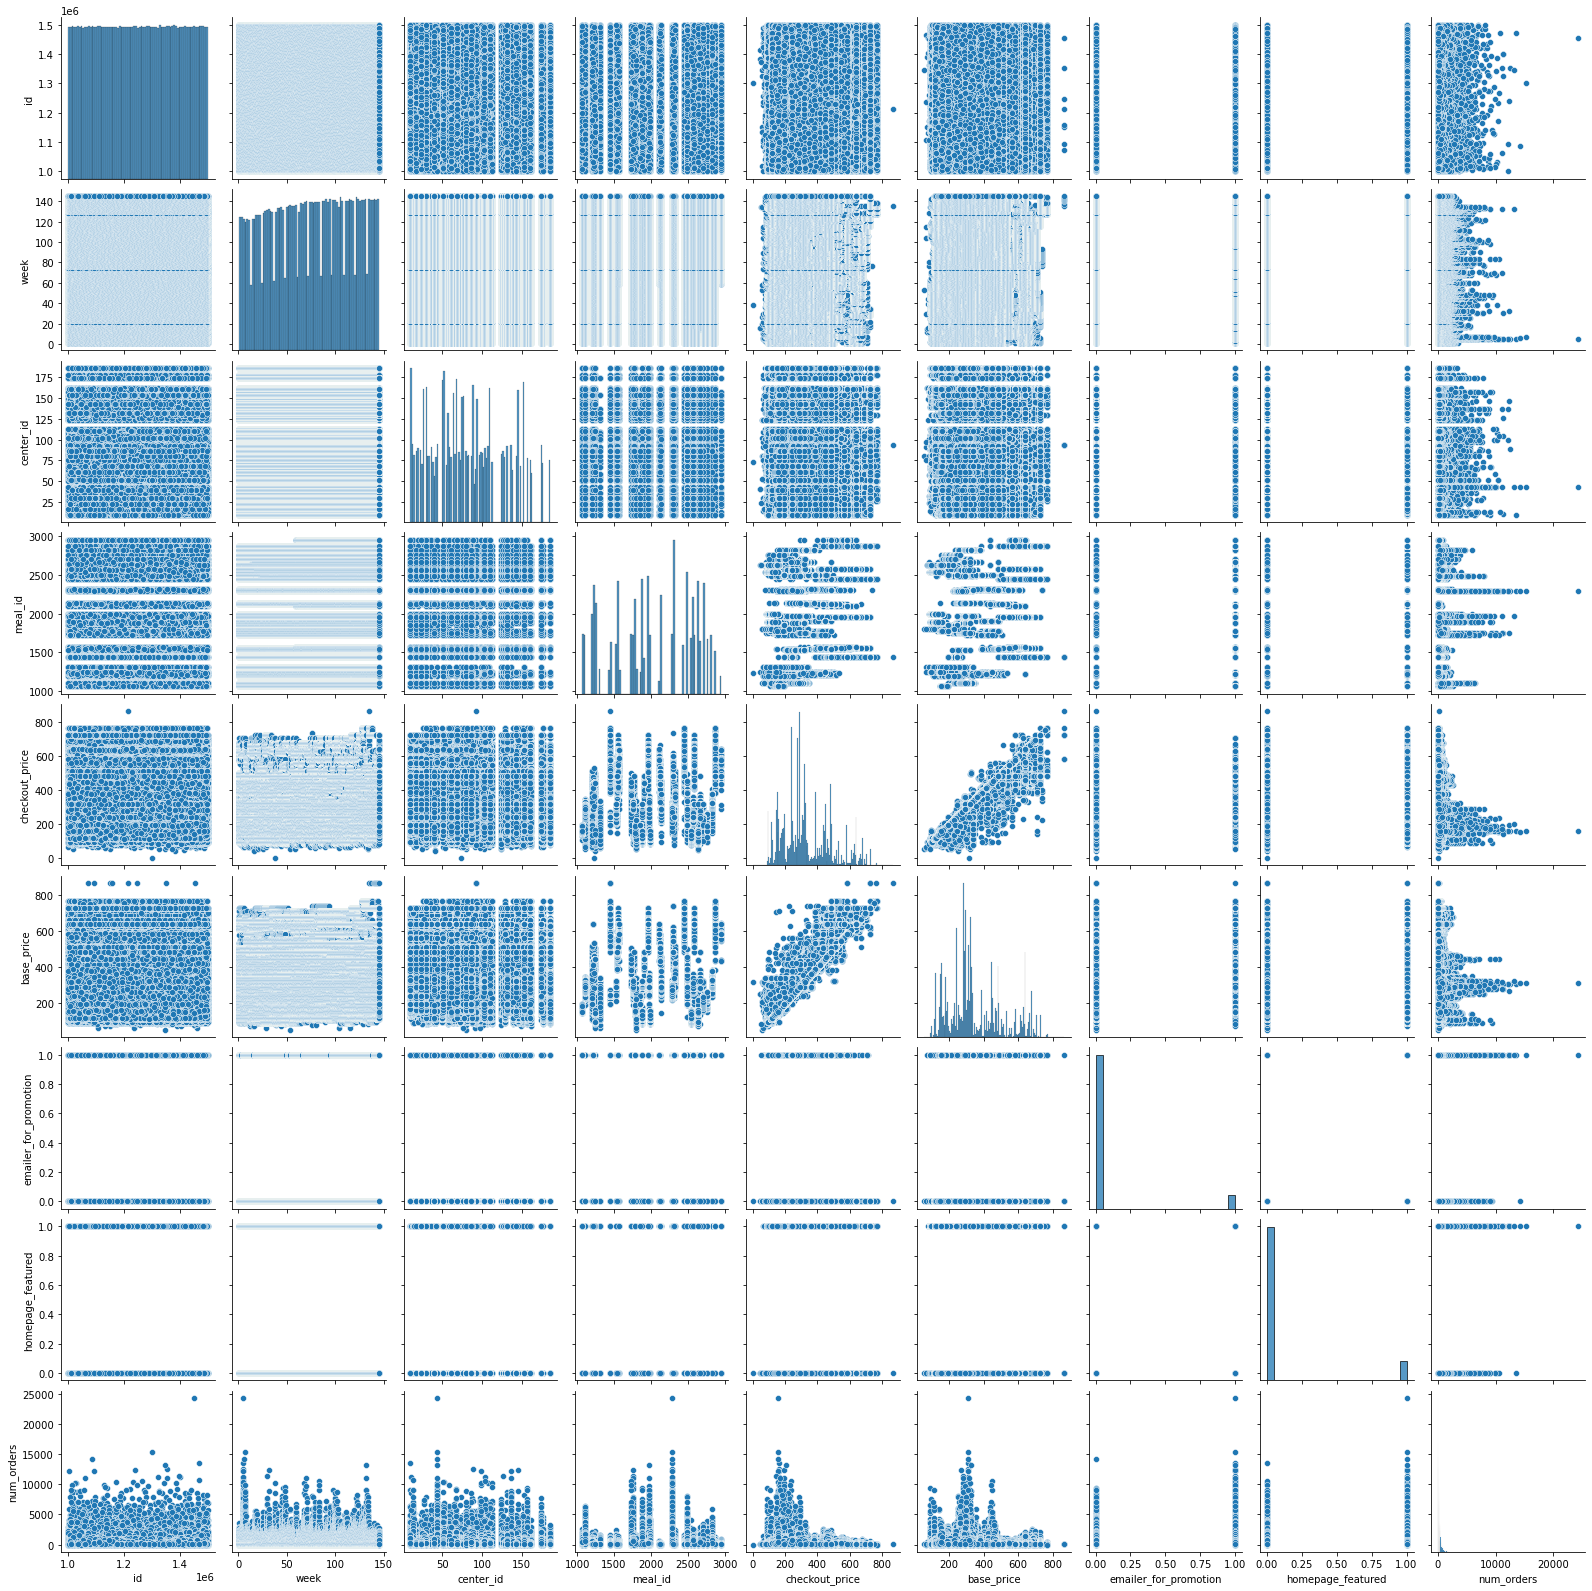

In [57]:
sns.pairplot(train)

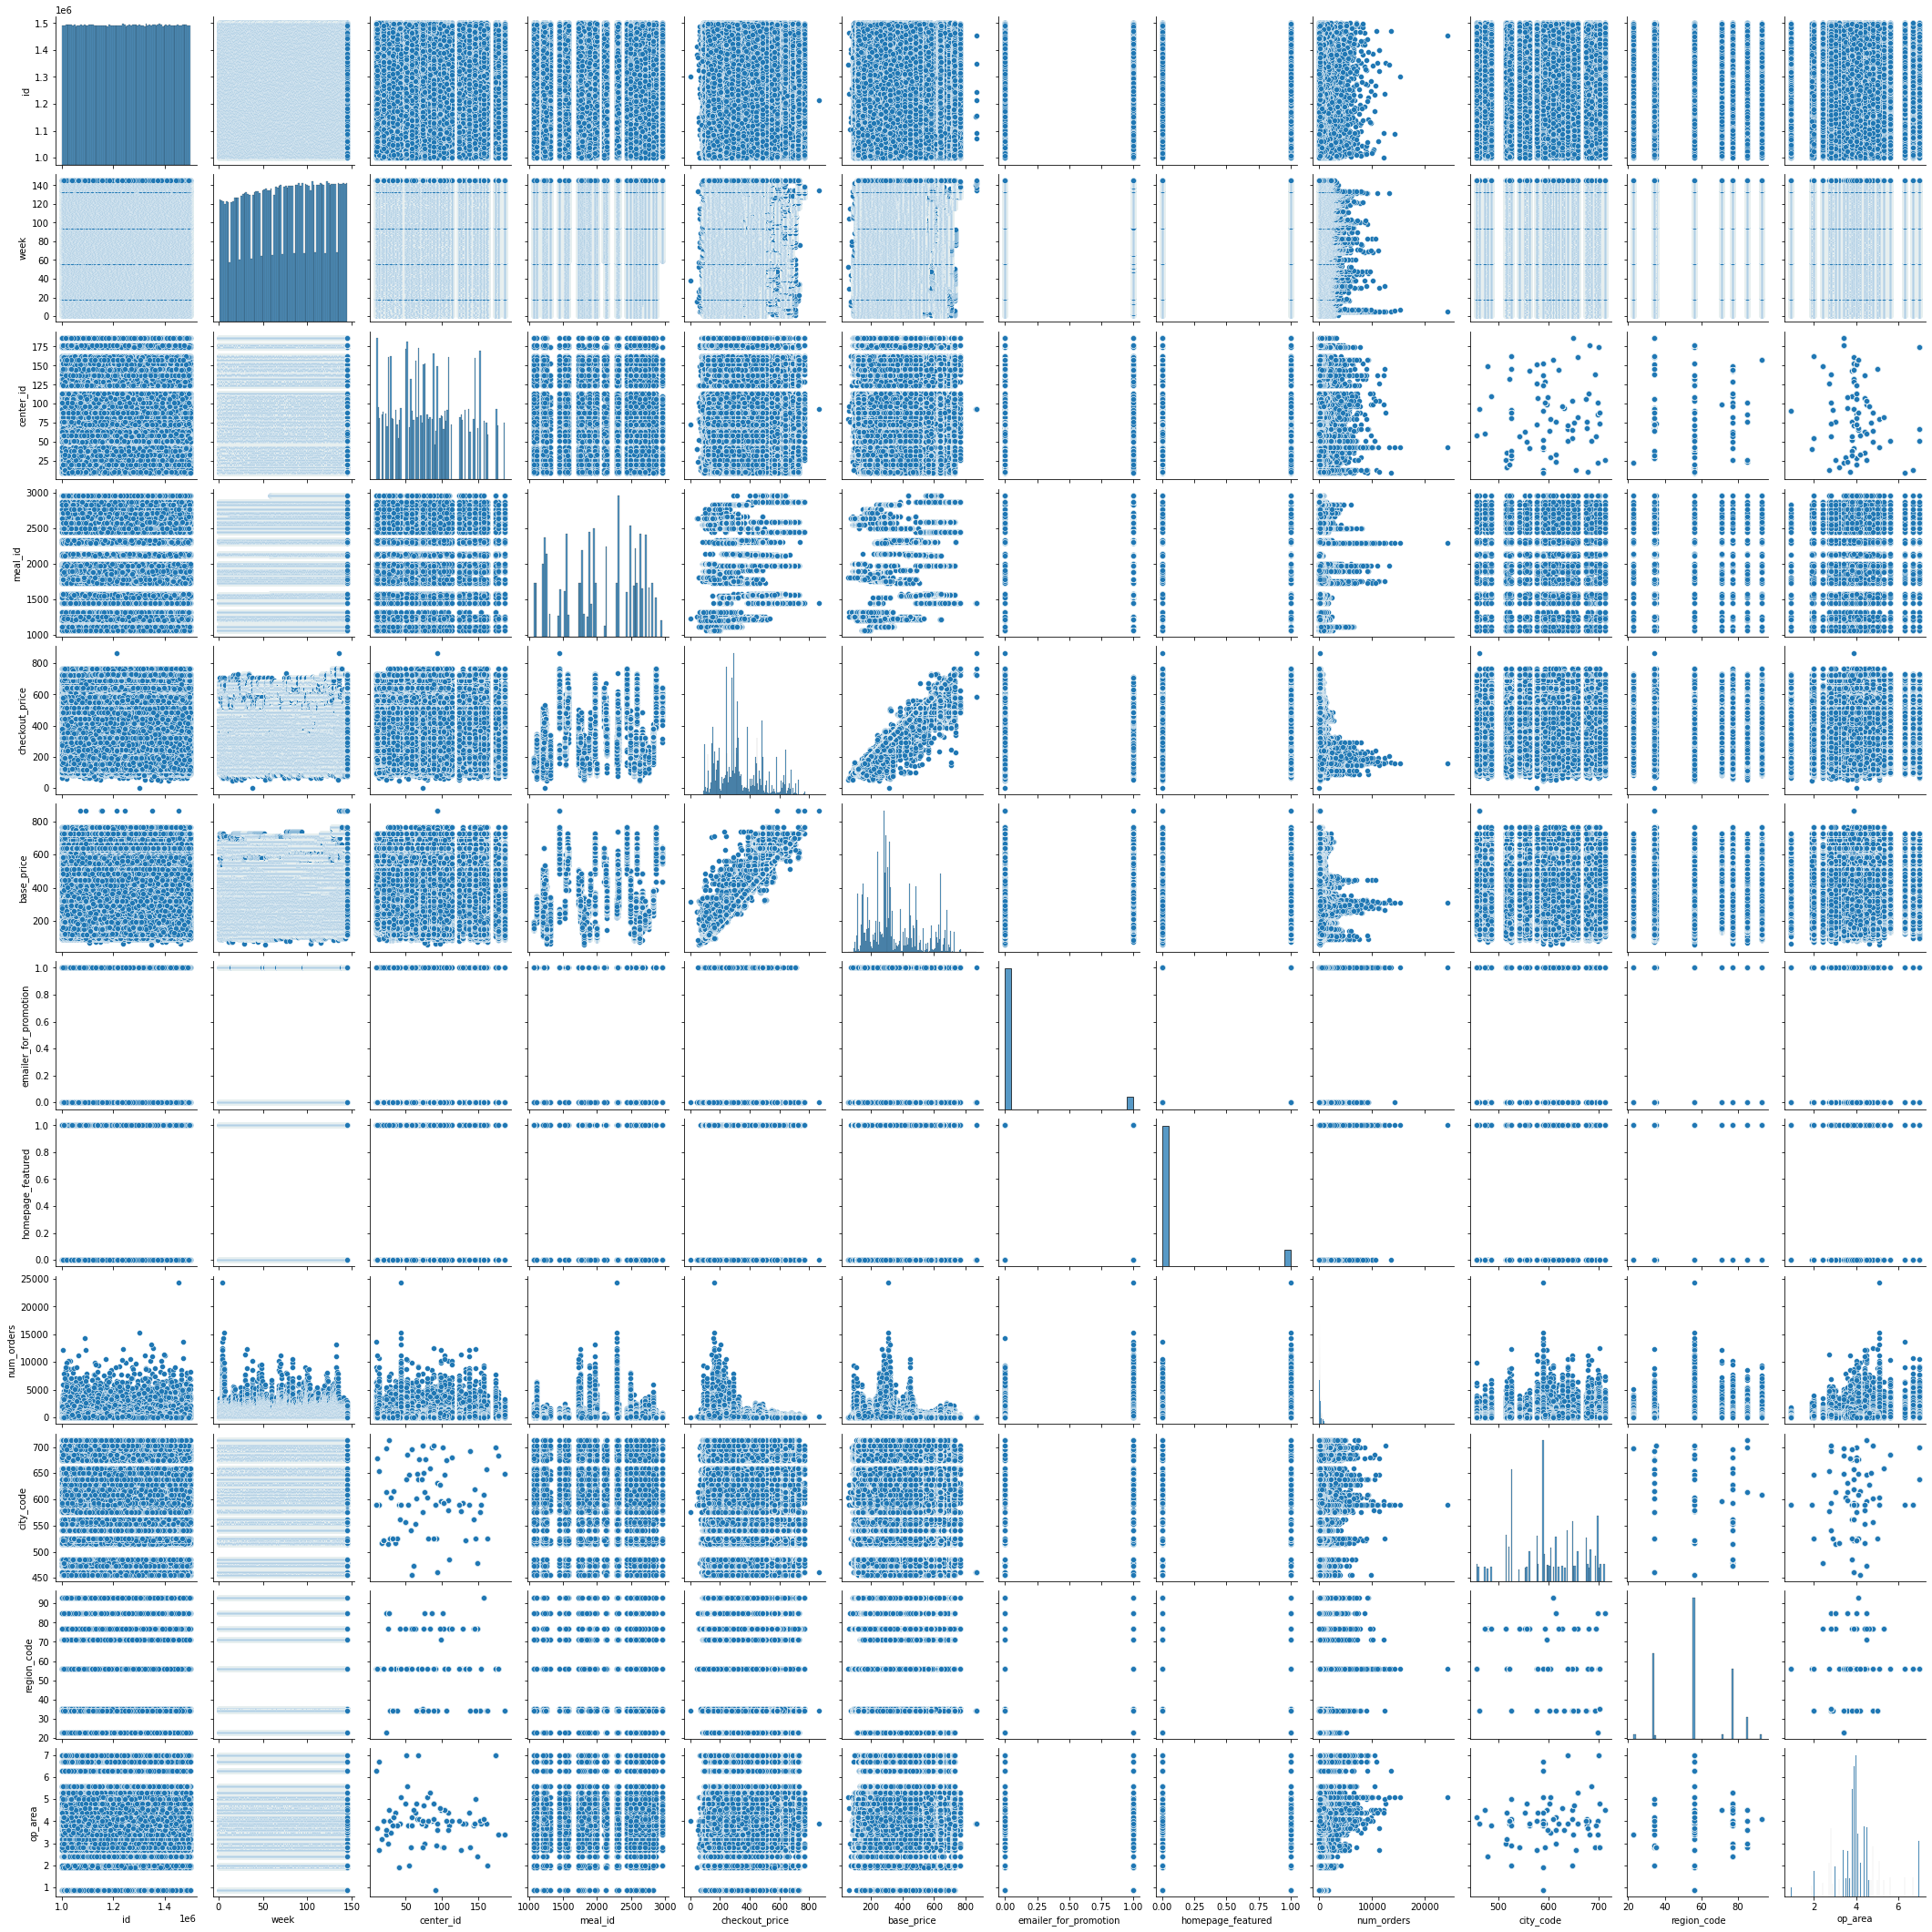

In [58]:
sns.pairplot(data)

Above exercise was to identify any apparrent trends in number of orders/relationship with different variables.
No clear trend or relationship is observed

In [59]:
data['disc_price']=data['base_price']-data['checkout_price']
data['disc_perc']= (data['base_price']-data['checkout_price'])/data['base_price']

In [72]:
#Creating feature variable to get previous week's number of orders for same meal ID and center ID. Filling unmatched rows with 0s
data_prev_week = data.loc[:,['week','meal_id','center_id','num_orders']]
data_prev_week.rename(columns={'num_orders':'num_orders_prev_week'}, inplace = True)

In [73]:
data_prev_week['week'] = data_prev_week['week']+1
data_prev_week

week  meal_id  center_id  num_orders_prev_week
0          2     1885         55                   177
1          2     2444        113                    14
2          2     1525        113                    14
3          2     2704        113                   121
4          2     1248         52                    81
...      ...      ...        ...                   ...
456543   146     1778        145                   378
456544   146     1445         59                    40
456545   146     1770         73                    55
456546   146     2304         51                    80
456547   146     2104         61                    27

[456548 rows x 4 columns]

In [74]:
data_all_var = pd.merge(data,data_prev_week, how='left',left_on=['week','meal_id','center_id'], right_on=['week','meal_id','center_id'])

In [79]:
data_all_var=data_all_var.fillna(0)
data_all_var

id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885          136.83      152.29   
1       1409622     1        113     2444          658.63      660.63   
2       1203879     1        113     1525          244.50      282.33   
3       1235654     1        113     2704          242.50      280.33   
4       1393327     1         52     1248          247.35      247.35   
...         ...   ...        ...      ...             ...         ...   
456543  1184135   145        145     1778          160.05      160.08   
456544  1007940   145         59     1445          727.53      726.53   
456545  1154446   145         73     1770          440.38      442.38   
456546  1450789   145         51     2304          484.03      485.03   
456547  1443704   145         61     2104          581.03      582.03   

        emailer_for_promotion  homepage_featured  num_orders      category  \
0                           0                  0         177     Beverages   
1                           0                  0          14       Seafood   
2                           0                  0          14  Other Snacks   
3                           0                  0         121  Other Snacks   
4                           0                  0          81     Beverages   
...                       ...                ...         ...           ...   
456543                      1                  0         378     Beverages   
456544                      0                  1          40       Seafood   
456545                      0                  0          55       Biryani   
456546                      0                  0          80        Desert   
456547                      0                  0          27          Fish   

            cuisine  city_code  region_code center_type  op_area  disc_price  \
0              Thai        647           56      TYPE_C      2.0       15.46   
1       Continental        680           77      TYPE_C      4.0        2.00   
2              Thai        680           77      TYPE_C      4.0       37.83   
3              Thai        680           77      TYPE_C      4.0       37.83   
4            Indian        685           56      TYPE_B      5.6        0.00   
...             ...        ...          ...         ...      ...         ...   
456543      Italian        620           77      TYPE_A      3.9        0.03   
456544  Continental        456           56      TYPE_A      4.2       -1.00   
456545       Indian        576           34      TYPE_A      4.0        2.00   
456546       Indian        638           56      TYPE_A      7.0        1.00   
456547  Continental        473           77      TYPE_A      4.5        1.00   

        disc_perc  num_orders_prev_week  
0        0.101517                   0.0  
1        0.003027                   0.0  
2        0.133992                   0.0  
3        0.134948                   0.0  
4        0.000000                   0.0  
...           ...                   ...  
456543   0.000187                 432.0  
456544  -0.001376                 242.0  
456545   0.004521                  13.0  
456546   0.002062                  28.0  
456547   0.001718                  53.0  

[456548 rows x 18 columns]

<AxesSubplot:>

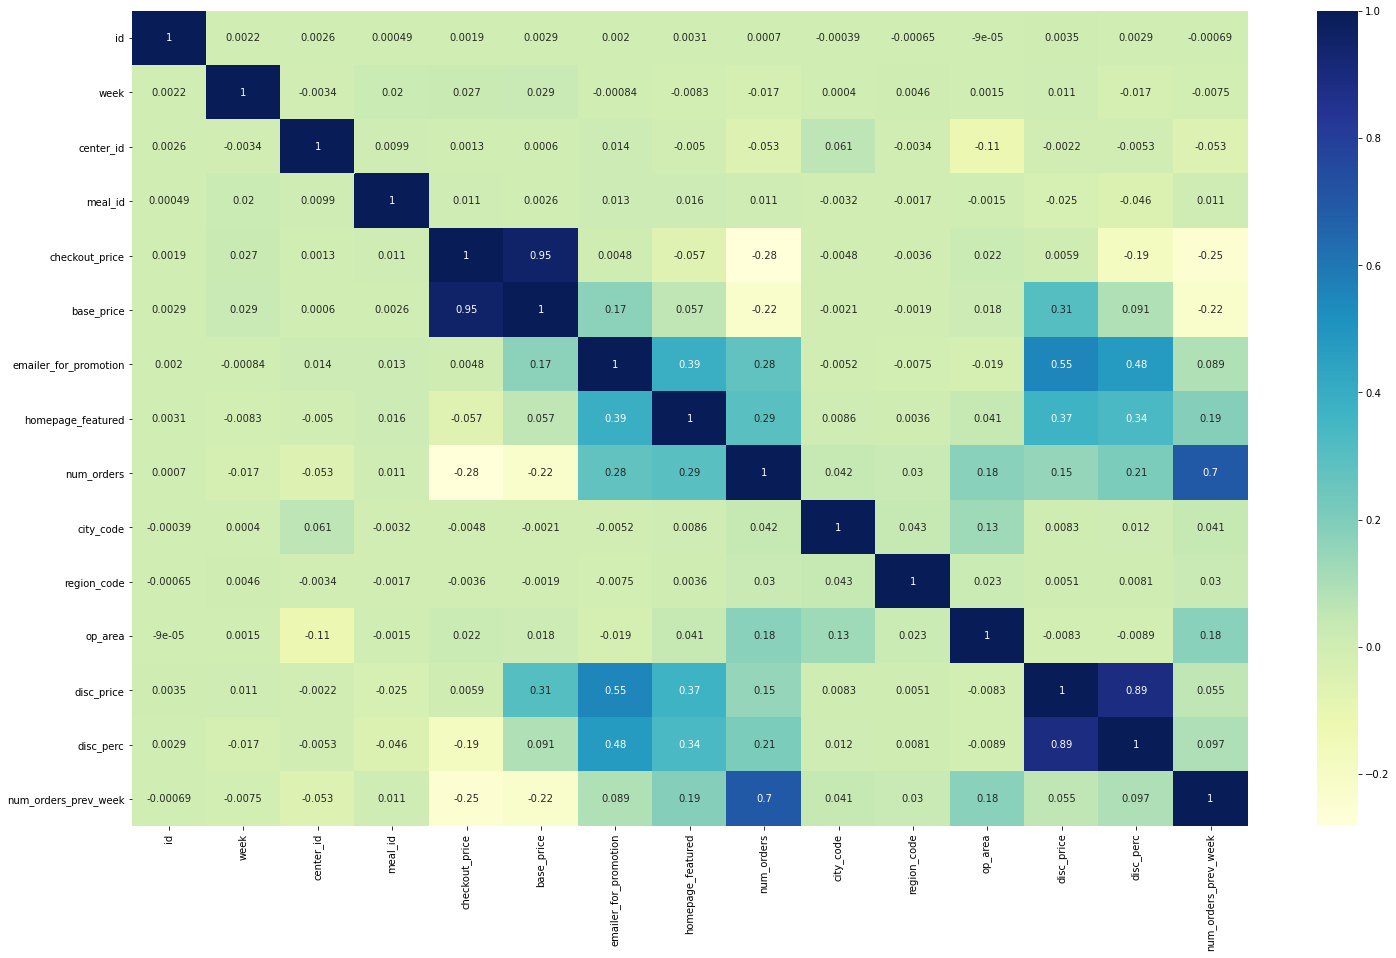

In [80]:
plt.figure(figsize=(25,15))
c=data_all_var.corr()
sns.heatmap(c,cmap="YlGnBu",annot=True)

### New list of variables to be used a features for training model
We see that the new variables which have been created have a comparatively high correlation with the target variable (number of orders)

Going forward, this python file focuses only on the demand forecasting aspect of the case study

### Dealing with categorical variables

The current training data has many categorical variables, as listed below -
1. center_id
2. meal_id
3. emailer_for_promotion
4. homepage_featured
5. city_code
6. region_code
7. Category
8. Cuisine
9. center type

All the above categorical variables are present in a numerical format except the last 3, thus allowing us to directly use the variables as is.
All the categorical variables are also nominal in nature (cannot be ordered)

Other ways to treat categorical variables -
1. One hot encoding (creating binary flags for each category)
2. Count encoding (replacing each category with its frequency in the data)

We will test all categorical variables to identify if any two categories have the same count. If two categories have the same count, it will lead to information loss in Count encoding

In [93]:
gp1 = data_all_var.groupby('center_id')['center_id'].count().reset_index(name='count')
print(len(pd.unique(gp1['count'])))
print(len(gp1['count']))

76
77


In [94]:
gp1 = data_all_var.groupby('meal_id')['meal_id'].count().reset_index(name='count')
print(len(pd.unique(gp1['count'])))
print(len(gp1['count']))

50
51


In [95]:
gp1 = data_all_var.groupby('emailer_for_promotion')['emailer_for_promotion'].count().reset_index(name='count')
print(len(pd.unique(gp1['count'])))
print(len(gp1['count']))

2
2


In [96]:
gp1 = data_all_var.groupby('city_code')['city_code'].count().reset_index(name='count')
print(len(pd.unique(gp1['count'])))
print(len(gp1['count']))

50
51


In [97]:
gp1 = data_all_var.groupby('region_code')['region_code'].count().reset_index(name='count')
print(len(pd.unique(gp1['count'])))
print(len(gp1['count']))

8
8


In [131]:
gp2 = data_all_var.groupby('category')['category'].count().reset_index(name='count')
print(len(pd.unique(gp2['count'])))
print(len(gp2['count']))
print(gp2)

14
14
        category   count
0      Beverages  127890
1        Biryani   20614
2         Desert   29294
3         Extras   13562
4           Fish   10187
5   Other Snacks   29379
6          Pasta   27694
7          Pizza   33138
8      Rice Bowl   33408
9          Salad   28559
10      Sandwich   33291
11       Seafood   26916
12          Soup   12675
13      Starters   29941


In [132]:
gp3 = data_all_var.groupby('center_type')['center_type'].count().reset_index(name='count')
print(len(pd.unique(gp3['count'])))
print(len(gp3['count']))
print(gp3)

3
3
  center_type   count
0      TYPE_A  262881
1      TYPE_B   94074
2      TYPE_C   99593


In [133]:
gp4 = data_all_var.groupby('cuisine')['cuisine'].count().reset_index(name='count')
print(len(pd.unique(gp4['count'])))
print(len(gp4['count']))
print(gp4)

4
4
       cuisine   count
0  Continental  102795
1       Indian  112612
2      Italian  122925
3         Thai  118216


1. As we can see, three of the 6 numerical categorical values have categories with the same count. As such, using Count Encoding will lead to data loss
2. Using one-hot encoding will create over 150 variables for all categories. This will make model training slow and resource intensive.
3. For category, center_type and cuisine, we will use count encoding as there is no data loss


In [128]:
nominal_enc = ce.CountEncoder(cols=['category', 'cuisine', 'center_type']).fit(data_all_var)

data_all_var_enc = nominal_enc.transform(data_all_var)
data_all_var_enc

id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885          136.83      152.29   
1       1409622     1        113     2444          658.63      660.63   
2       1203879     1        113     1525          244.50      282.33   
3       1235654     1        113     2704          242.50      280.33   
4       1393327     1         52     1248          247.35      247.35   
...         ...   ...        ...      ...             ...         ...   
456543  1184135   145        145     1778          160.05      160.08   
456544  1007940   145         59     1445          727.53      726.53   
456545  1154446   145         73     1770          440.38      442.38   
456546  1450789   145         51     2304          484.03      485.03   
456547  1443704   145         61     2104          581.03      582.03   

        emailer_for_promotion  homepage_featured  num_orders  category  \
0                           0                  0         177    127890   
1                           0                  0          14     26916   
2                           0                  0          14     29379   
3                           0                  0         121     29379   
4                           0                  0          81    127890   
...                       ...                ...         ...       ...   
456543                      1                  0         378    127890   
456544                      0                  1          40     26916   
456545                      0                  0          55     20614   
456546                      0                  0          80     29294   
456547                      0                  0          27     10187   

        cuisine  city_code  region_code  center_type  op_area  disc_price  \
0        118216        647           56        99593      2.0       15.46   
1        102795        680           77        99593      4.0        2.00   
2        118216        680           77        99593      4.0       37.83   
3        118216        680           77        99593      4.0       37.83   
4        112612        685           56        94074      5.6        0.00   
...         ...        ...          ...          ...      ...         ...   
456543   122925        620           77       262881      3.9        0.03   
456544   102795        456           56       262881      4.2       -1.00   
456545   112612        576           34       262881      4.0        2.00   
456546   112612        638           56       262881      7.0        1.00   
456547   102795        473           77       262881      4.5        1.00   

        disc_perc  num_orders_prev_week  
0        0.101517                   0.0  
1        0.003027                   0.0  
2        0.133992                   0.0  
3        0.134948                   0.0  
4        0.000000                   0.0  
...           ...                   ...  
456543   0.000187                 432.0  
456544  -0.001376                 242.0  
456545   0.004521                  13.0  
456546   0.002062                  28.0  
456547   0.001718                  53.0  

[456548 rows x 18 columns]

In [129]:
nominal_enc

CountEncoder(cols=['category', 'cuisine', 'center_type'],
             combine_min_nan_groups=True)

## Model building

1. Up to now, we have completed our EDA (in python, excel and tableu combined)
2. We have generated new feature variables (discount, discount percentage, number of orders in previous week, meal info and center info


Going forward, we will start building our model

As this is a time series data, algorithms such as ARIMA or Seasonal ARIMA could be used. However, those models are better suited when the dependent variable changes only with time, and there are no other independent variables impacting it.

In our case, we have built a list of feature variables which we can use to predict the demand accurately. We will use the following algorithms to build the training models -
1. Linear Regression
2. Random Forest (Regressor)
3. XGBoost

We'll use RMSE to shortlist the best model and then use the finalised model in the testing data to predict the number of orders.

In [134]:
x_train,x_test,y_train,y_test = train_test_split(data_all_var_enc.drop(['id','num_orders'],axis=1),data_all_var_enc['num_orders'],test_size=0.2,random_state=95)

In [135]:
x_train

week  center_id  meal_id  checkout_price  base_price  \
198782    66         80     1847          247.38      247.38   
309294   100         10     1207          342.44      343.44   
415392   133         61     2640          319.13      321.13   
284211    93         76     2640          292.03      290.03   
49164     18        137     2826          196.00      319.13   
...      ...        ...      ...             ...         ...   
30654     11         99     2631          253.23      253.23   
448630   143        106     2664          284.24      330.77   
60947     22         59     2631          154.26      253.23   
269609    88         72     2704          242.50      291.03   
187798    63         30     1543          486.03      485.03   

        emailer_for_promotion  homepage_featured  category  cuisine  \
198782                      0                  0     12675   118216   
309294                      0                  0    127890   102795   
415392                      0                  0     29941   118216   
284211                      0                  0     29941   118216   
49164                       1                  1     33291   122925   
...                       ...                ...       ...      ...   
30654                       0                  0    127890   112612   
448630                      0                  0     28559   122925   
60947                       0                  0    127890   112612   
269609                      0                  0     29379   118216   
187798                      0                  0     29294   112612   

        city_code  region_code  center_type  op_area  disc_price  disc_perc  \
198782        604           56        99593      5.1        0.00   0.000000   
309294        590           56        94074      6.3        1.00   0.002912   
415392        473           77       262881      4.5        2.00   0.006228   
284211        614           85       262881      3.0       -2.00  -0.006896   
49164         590           56       262881      4.4      123.13   0.385830   
...           ...          ...          ...      ...         ...        ...   
30654         596           71       262881      4.5        0.00   0.000000   
448630        675           34       262881      4.0       46.53   0.140672   
60947         456           56       262881      4.2       98.97   0.390830   
269609        638           56        99593      3.9       48.53   0.166753   
187798        604           56       262881      3.5       -1.00  -0.002062   

        num_orders_prev_week  
198782                  13.0  
309294                 150.0  
415392                 229.0  
284211                  69.0  
49164                  405.0  
...                      ...  
30654                   54.0  
448630                 189.0  
60947                   68.0  
269609                  80.0  
187798                  42.0  

[365238 rows x 16 columns]

In [136]:
print(456548*0.8)

365238.4


Train test split successful

In [137]:
#Training the Linear Regression model
model = LinearRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [138]:
print("R2 score:",r2_score(y_test, y_pred))
print("MSE score:",mean_squared_error(y_test, y_pred))
print("RMSE:",sqrt(mean_squared_error(y_test, y_pred))) #To be used for final model selection

R2 score: 0.5469959493274232
MSE score: 74408.36948227198
RMSE: 272.7789755136418


In [145]:
xg = XGBRegressor()
xg.fit(x_train, y_train)
y_pred_xgb = xg.predict(x_test) 



In [146]:
print("R2 score:",r2_score(y_test, y_pred_xgb))
print("MSE score:",mean_squared_error(y_test, y_pred_xgb))
print("RMSE:",sqrt(mean_squared_error(y_test, y_pred_xgb)))

R2 score: 0.8434085699107181
MSE score: 25720.990729644258
RMSE: 160.37765034332014


In [154]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)


RandomForestRegressor()

In [155]:
y_pred_rf = rf.predict(x_test)

print("R2 score:",r2_score(y_test, y_pred_rf))
print("MSE score:",mean_squared_error(y_test, y_pred_rf))
print("RMSE:",sqrt(mean_squared_error(y_test, y_pred_rf)))

R2 score: 0.8352586567067991
MSE score: 27059.658125720078
RMSE: 164.49820098019333


In [152]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

print("R2 score:",r2_score(y_test, y_pred_knn))
print("MSE score:",mean_squared_error(y_test, y_pred_knn))
print("RMSE:",sqrt(mean_squared_error(y_test, y_pred_knn)))

R2 score: 0.6621835713756296
MSE score: 55488.17852940532
RMSE: 235.5592887775927


### Hyperparameter tuning
Due to limited time, and availability of only CPU resources on my laptop, hyperparameter is currently not implemented.
However, the following parameters can be tuned using gridsearch -
1. Learning rate for XGB - slower learning to prevent overfitting of model
2. Number of estimators (number of trees used in the prediction) for XGB, random forest
3. max_depth - setting the maximum depth of the trees. Deeper trees allow for further segregation - for XGB and Random Forest
4. Number of neighbours for KNN

The above are commonly used hyperparameters for tuning models. Apart from this, kfold sampling can be used to split the data into multiple folds for better model training.



## Model Results
We tested 4 models for food demand prediction. The results (RMSE values) for the 4 models are shared below-
1. Linear Regression - 272
2. XGBoost - 160
3. Random Forest - 164
4. KNN - 235

XGBoost has performed the best out of all models.